In [1]:
from MotionGPT import *

In [2]:
torch.__version__

'1.7.0'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # device

In [4]:
loader = FBXDataLoader("FBXDataStand//", has_translate=True)
loader.LoadData()

FBXDataLoader loading data...



Hip Spine distance as scale:  3.971305111266949


In [5]:
print(len(loader.raw_data),len(loader.raw_data[0]),len(loader.raw_data[0][0]),len(loader.raw_data[0][0][0]))

298 46 65 6


In [6]:
loader.translate_scale

19.856525556334745

In [7]:
loader.PrepareTrainingData(training_joint_index=[i for i in range(len(G_MIXAMO_JOINTS))])

In [8]:
print(len(loader.all_data),len(loader.all_data[0]),len(loader.all_data[0][0]))
print(len(loader.all_data),len(loader.all_data[-1]),len(loader.all_data[-1][0]))

3528 4 198
3528 8 198


In [9]:
print(len(loader.train_data),len(loader.train_data[0]),len(loader.train_data[0][1]))

2822 9 198


# Transformer

In [117]:
from SeqTransformer import *

input_dim = 198

model = build_seq_vae(input_dim, 2)

In [118]:
import numpy as np
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

6266118


In [119]:
model.load_state_dict(torch.load("record/2020_12_08_11_06_18.pt").state_dict())

<All keys matched successfully>

In [120]:
#build model for training
if torch.cuda.is_available():
    model = model.cuda()

In [135]:
batch_x, batch_mask = next(iter(loader.next_batch(batch_size=16)))

In [136]:
batch_x = batch_x.to(device)
batch_mask = batch_mask.to(device)

batch_x_decoder_input = batch_x[:,1:, :] # Batch x (Length - 1) x Dim
batch_x_encoder_input = batch_x[:,:-1, :] # Batch x (Length - 1) x Dim

batch_mask_encoder_input = batch_mask[:, 1:] # Batch x (Length - 1)

batch_output, gaussian_params = model(batch_x_encoder_input, batch_x_decoder_input)


In [137]:
batch_x_decoder_input.shape

torch.Size([16, 32, 198])

In [138]:
batch_output.shape

torch.Size([16, 32, 198])

In [139]:
torch.mean((batch_output - batch_x_decoder_input)**2)

tensor(1096.7168, device='cuda:0', grad_fn=<MeanBackward0>)

In [141]:
differences = (batch_output - batch_x_decoder_input)**2

In [142]:
differences.shape

torch.Size([16, 32, 198])

In [127]:
differences = differences.view(-1).data.cpu()

In [128]:
differences = np.asarray(differences)

In [130]:
differences[:20]

array([1.59631670e-02, 2.06513405e-02, 2.79721804e-02, 2.14542844e-03,
       7.87983894e-01, 4.00245428e-01, 3.67561054e+00, 1.27786171e+00,
       6.20582163e-01, 7.49583900e-01, 2.61193252e+00, 2.11998248e+00,
       6.06320381e-01, 2.37586570e+00, 1.93475866e+00, 2.67087784e+01,
       1.51021138e-01, 8.15830994e+00, 1.42563945e-02, 3.13615952e+01],
      dtype=float32)

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

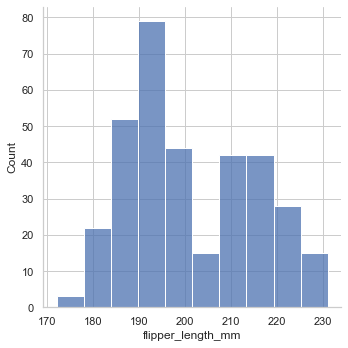

In [132]:
penguins = sns.load_dataset("penguins")
sns.displot(penguins["flipper_length_mm"])
plt.show()

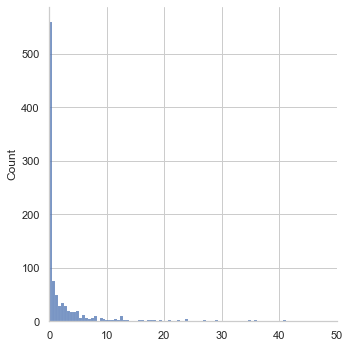

In [133]:
sns.displot(differences[:1000])
plt.xlim(0, 50)
plt.show()

In [ ]:
sns.kdeplot(differences[:1000])
plt.xlim(0, 50)
plt.show()

In [34]:
differences[:1000]

array([7.87730154e-04, 7.41467206e-03, 9.46347974e-03, 1.05869389e+00,
       3.42653058e-02, 7.05535746e+00, 8.03598285e-01, 1.35121429e+00,
       3.35250258e-01, 3.68032664e-01, 1.40647745e+00, 1.00323362e-02,
       1.91124126e-01, 1.07175112e+00, 3.22156027e-02, 2.14281138e-02,
       2.16956615e+00, 1.15328457e-03, 1.00679596e+02, 6.31560211e+01,
       1.20750022e+00, 5.77243185e-03, 1.36477044e-02, 2.99021993e-02,
       6.63199544e-01, 1.12441702e+01, 5.93239861e+01, 4.51141319e+01,
       1.02779984e+02, 1.45010865e+00, 1.87569812e-01, 1.89181197e+00,
       1.11477697e+00, 1.19423304e+01, 3.94791565e+01, 1.04445229e+01,
       3.29564056e+01, 1.90526905e+01, 7.80996227e+00, 2.52978992e+00,
       6.17987967e+00, 1.90590302e+02, 1.20056610e+01, 4.02211189e+00,
       9.09791565e+00, 2.98524778e-02, 2.13535340e-03, 1.03440741e-02,
       9.80618134e+01, 1.43164426e-01, 2.26943092e+01, 5.66130486e+01,
       2.51757074e-02, 1.13209255e-01, 5.92404509e+00, 1.13065131e-01,
      

# VRNN

In [10]:
input_dim = len(loader.train_data[0][1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # device

In [11]:
from Params import *
from VRNN import *

In [12]:
model = VRNN(input_dim, h_dim, z_dim, n_layers, device)
#model.to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
model.load_state_dict(torch.load("runs/2020_12_14_16_33_16_nr.pth").state_dict())

<All keys matched successfully>

In [14]:
for batch_data, pad_data in loader.next_batch(batch_size, train_mode=False):
    batch_data = batch_data.to(device)
    pad_data = pad_data.to(device)

    kld_loss, mse_loss, _, _ = model(batch_data, pad_data)
    
    break

In [16]:
mse_loss / len(batch_data)

tensor(1716.9915, device='cuda:0', grad_fn=<DivBackward0>)

In [17]:
x_rec = model.reconstruct(batch_data)

In [18]:
batch_data.shape

torch.Size([32, 42, 198])

In [19]:
x_rec.shape

torch.Size([32, 42, 198])

In [36]:
differences = (x_rec - batch_data)**2

In [27]:
differences = differences.view(-1).data.cpu()

In [31]:
differences = np.asarray(differences)

In [37]:
differences.shape

torch.Size([32, 42, 198])

In [143]:
differences = differences.view(-1, 198)

In [144]:
differences = np.asarray(differences.data.cpu())

In [146]:
differences.shape

(512, 198)

In [60]:
import pandas as pd

In [105]:
dataset = pd.DataFrame(np.sqrt(differences))

s = pd.DataFrame(dataset.unstack())

s = s.droplevel(1)

s.reset_index(inplace=True)

s['model'] = "VRNN"

s.head()

len(s)

body_part = []
for i in range(len(s)):
    joint_index = s['index'][i]
    if joint_index < 4:
        body_part.append("Body")
    elif joint_index < 7:
        body_part.append("Head")
    elif (joint_index >= 7 and joint_index < 11) or (joint_index >= 31 and joint_index < 35):
        body_part.append("Arm")
    elif joint_index >= 55:
        body_part.append("Leg")
    else:
        body_part.append("Hand")

s["Body part"] = body_part

s.columns = ['index', 'error', 'model', 'body part']

s.head()

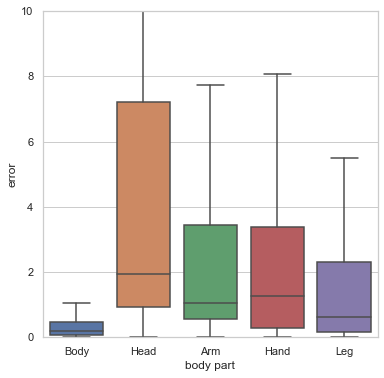

In [155]:

sns.boxplot(x="body part", y="error", data=s,showfliers=False)
plt.ylim(0, 10)
plt.show()

In [147]:
dataset = pd.DataFrame(np.sqrt(differences))

s2 = pd.DataFrame(dataset.unstack())

s2 = s2.droplevel(1)

s2.reset_index(inplace=True)

s2['model'] = "Transformer-VAE"

s2.head()

len(s2)

body_part = []
for i in range(len(s2)):
    joint_index = s['index'][i]
    if joint_index < 4:
        body_part.append("Body")
    elif joint_index < 7:
        body_part.append("Head")
    elif (joint_index >= 7 and joint_index < 11) or (joint_index >= 31 and joint_index < 35):
        body_part.append("Arm")
    elif joint_index >= 55:
        body_part.append("Leg")
    else:
        body_part.append("Hand")

s2["Body part"] = body_part

s2.columns = ['index', 'error', 'model', 'body part']

s2.head()

,index,error,model,body part
0,0,0.131832,Transformer-VAE,Body
1,0,0.015932,Transformer-VAE,Body
2,0,0.053306,Transformer-VAE,Body
3,0,0.142861,Transformer-VAE,Body
4,0,0.112027,Transformer-VAE,Body


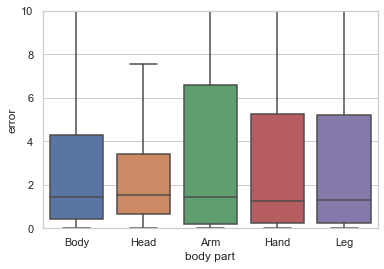

In [149]:
sns.boxplot(x="body part", y="error", data=s2,showfliers=False)
plt.ylim(0, 10)
plt.show()

In [150]:
ss = pd.concat([s, s2], axis=0, sort=False)

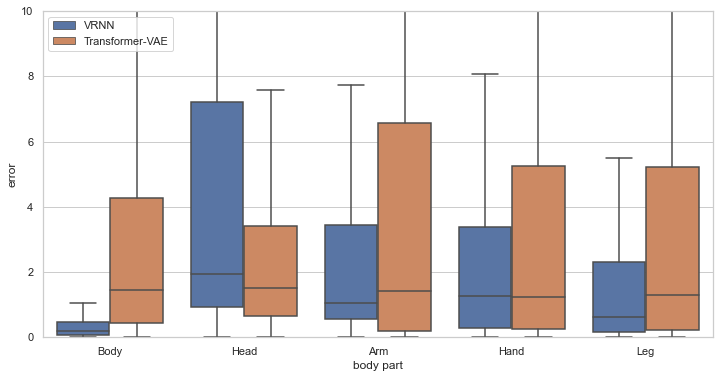

In [158]:
plt.figure(figsize=(12,6))
sns.boxplot(x="body part", y="error", hue="model", data=ss,showfliers=False)
plt.ylim(0, 10)
plt.legend(loc='upper left')
plt.show()

In [160]:
differences.shape

(512, 198)

In [167]:
print(np.mean(s['error'] < 1.0))
print(np.mean(s2['error'] < 1.0))


0.5689108345358346
0.45243450126262624


In [168]:
print(np.mean(s['error'] < 5.0))
print(np.mean(s2['error'] < 5.0))

0.8729933261183261
0.7451665088383839


In [166]:
print(np.mean(s['error'] > 10.0))
print(np.mean(s2['error'] > 10.0))

0.03298986892736893
0.15471117424242425
